npe          n=20000  med=[ 0.006  0.     0.026 -0.056  0.022  0.051  0.484]
rnpe         n=20000  med=[-0.186 -0.363 -0.575 -0.802  0.182  0.47   0.312]
pnpe         n=20000  med=[ 0.147 -1.     0.132 -0.29   1.     1.     0.04 ]
prnpe        n=20000  med=[ 0.572 -0.172  0.728  0.822 -0.645 -0.254  0.097]
rf_abc_npe   n=20000  med=[ 0.184 -0.166  0.997 -0.91  -0.738 -1.     0.435]
rf_abc_rnpe  n=20000  med=[ 0.549 -0.205  0.325  0.108 -0.591 -0.238  0.104]


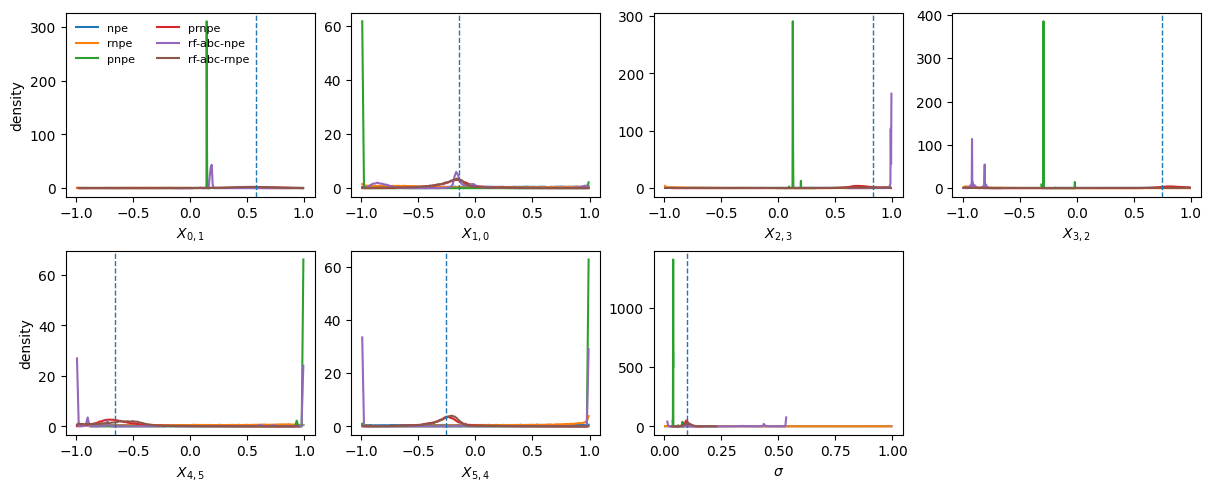

In [1]:
# %%
from __future__ import annotations
from pathlib import Path
import re, numpy as np, matplotlib.pyplot as plt

# --- config (edit) ---
RESULTS_ROOT = Path("../results/hpc/svar")  # folder containing method subdirs
GROUP = "th_p10.579_p2-0.143_p30.836_p40.745_p5-0.660_p6-0.254_p70.1-K_6-T_1000-obs_true-n_sims_20000-q_0.2"
SEED = 0
METHOD_DIRS = ["npe", "rnpe", "pnpe", "prnpe", "rf_abc_npe", "rf_abc_rnpe"]
THETA_LABELS = [
    r"$X_{0,1}$",
    r"$X_{1,0}$",
    r"$X_{2,3}$",
    r"$X_{3,2}$",
    r"$X_{4,5}$",
    r"$X_{5,4}$",
    r"$\sigma$",
]
THETA_REF = np.array([0.579, -0.143, 0.836, 0.745, -0.660, -0.254, 0.1])


# --- helpers ---
def _latest_run(p: Path) -> Path | None:
    cand = [
        d for d in p.iterdir() if d.is_dir() and re.fullmatch(r"\d{8}-\d{6}", d.name)
    ]
    return max(cand, key=lambda d: d.stat().st_mtime) if cand else None


def _load_theta_samples(npz_path: Path) -> np.ndarray:
    with np.load(npz_path, allow_pickle=True) as data:
        for k in ("samples", "posterior_samples", "theta", "thetas", "params"):
            if k in data:
                arr = np.asarray(data[k])
                break
        else:
            arr = np.asarray(next(iter(data.values())))
    arr = np.asarray(arr)
    arr = arr.reshape(-1, arr.shape[-1]) if arr.ndim > 1 else arr[:, None]
    return arr.astype(float)


def _histline(x: np.ndarray, bins: int = 128):
    c, e = np.histogram(x, bins=bins, density=True)
    return 0.5 * (e[1:] + e[:-1]), c


# --- load ---
post_by_method: dict[str, np.ndarray] = {}
for mdir in METHOD_DIRS:
    base = RESULTS_ROOT / mdir / GROUP / f"seed-{SEED}"
    if not base.exists():
        continue
    run = _latest_run(base)
    if run is None:
        continue
    f = run / "posterior_samples.npz"
    if not f.exists():
        f = run / "posterior_samples_robust.npz"
    try:
        post_by_method[mdir] = _load_theta_samples(f)
    except Exception as e:
        print(f"[skip] {mdir}: {e}")

if not post_by_method:
    print("No posterior samples found.")
    raise SystemExit

# --- quick sanity check ---
for name, smp in post_by_method.items():
    q05, q50, q95 = np.quantile(smp, [0.05, 0.5, 0.95], axis=0)
    print(f"{name:12s} n={len(smp):5d}  med={np.round(q50,3)}")

# --- plot 7 marginals ---
D = 7
ncols, nrows = 4, 2
fig, axes = plt.subplots(
    nrows, ncols, figsize=(3.0 * ncols, 2.4 * nrows), constrained_layout=True
)
axes = axes.ravel()
for d in range(D):
    ax = axes[d]
    for name, smp in post_by_method.items():
        x, y = _histline(smp[:, d], bins=128)
        ax.plot(x, y, label=name.replace("_", "-"))
    if THETA_REF is not None and len(THETA_REF) > d:
        ax.axvline(float(THETA_REF[d]), linestyle="--", linewidth=1.0)
    ax.set_xlabel(THETA_LABELS[d] if d < len(THETA_LABELS) else rf"$\theta_{d+1}$")
    if d % ncols == 0:
        ax.set_ylabel("density")
for j in range(D, len(axes)):
    axes[j].axis("off")
axes[0].legend(fontsize=8, ncol=2, frameon=False)
Path("figures").mkdir(parents=True, exist_ok=True)
plt.savefig("figures/svar_theta_posteriors.pdf", bbox_inches="tight")
plt.savefig("figures/svar_theta_posteriors.png", dpi=300, bbox_inches="tight")
plt.show()

In [6]:
# %%
from __future__ import annotations
from pathlib import Path
import re, json, numpy as np, matplotlib.pyplot as plt

# --- config (edit) ---
RESULTS_ROOT = Path("../results/hpc/svar")
GROUP = "th_p10.579_p2-0.143_p30.836_p40.745_p5-0.660_p6-0.254_p70.1-K_6-T_1000-obs_true-n_sims_20000-q_0.2"
SEED = 0
SAVE_DIR = Path("figures")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
LABELS = {"prnpe": "PRNPE–SMC‑ABC", "rf_abc_rnpe": "PRNPE–Random‑Forest"}
SIGMA_REF: float | None = (
    None  # set a float to force, otherwise auto‑read from config if present
)

# --- journal-ish style ---
plt.rcParams.update(
    {
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "font.size": 8.5,
        "axes.labelsize": 8.5,
        "axes.titlesize": 9,
        "xtick.labelsize": 7.5,
        "ytick.labelsize": 7.5,
        "legend.fontsize": 7.5,
        "lines.linewidth": 1.4,
    }
)


def _latest_run(p: Path) -> Path | None:
    cand = [
        d for d in p.iterdir() if d.is_dir() and re.fullmatch(r"\d{8}-\d{6}", d.name)
    ]
    return max(cand, key=lambda d: d.stat().st_mtime) if cand else None


def _load_theta(npz_path: Path) -> np.ndarray:
    with np.load(npz_path, allow_pickle=True) as data:
        for k in ("samples", "posterior_samples", "theta", "thetas", "params"):
            if k in data:
                a = np.asarray(data[k])
                break
        else:
            a = np.asarray(next(iter(data.values())))
    a = a.reshape(-1, a.shape[-1]) if a.ndim > 1 else a[:, None]
    return a.astype(float)


def _kde1d(s: np.ndarray, grid: np.ndarray) -> np.ndarray:
    s = s[np.isfinite(s)]
    if s.size == 0:
        return np.zeros_like(grid)
    sd = np.std(s, ddof=1) if s.size > 1 else 1.0
    bw = max(1e-3, 1.06 * sd * s.size ** (-1 / 5))
    z = (grid[None, :] - s[:, None]) / bw
    return np.exp(-0.5 * z * z).sum(0) / (s.size * bw * np.sqrt(2 * np.pi))


def _try_sigma_ref(run_dir: Path) -> float | None:
    if SIGMA_REF is not None:
        return float(SIGMA_REF)
    try:
        with open(run_dir / "config.json") as f:
            rt = json.load(f).get("run", {}).get("theta_true")
        return float(rt[-1]) if rt is not None else None
    except Exception:
        return None


# --- load σ for both methods ---
sigma, run_dirs = {}, {}
for mdir in ("prnpe", "rf_abc_rnpe"):
    base = RESULTS_ROOT / mdir / GROUP / f"seed-{SEED}"
    run = _latest_run(base)
    if run is None:
        raise FileNotFoundError(f"No run dir for {mdir}")
    f = run / "posterior_samples.npz"
    if not f.exists():
        f = run / "posterior_samples_robust.npz"
    th = _load_theta(f)
    sigma[mdir] = th[:, -1]  # σ is last parameter
    run_dirs[mdir] = run

# shared axes
both = np.concatenate([sigma["prnpe"], sigma["rf_abc_rnpe"]])
lo, hi = np.quantile(both[np.isfinite(both)], [0.0025, 0.9975])
xpad = 0.02 * (hi - lo)
xlim = (max(0.0, lo - xpad), hi + xpad)
grid = np.linspace(*xlim, 700)
ymax = max(_kde1d(sigma[m], grid).max() for m in sigma)
sigma_ref = _try_sigma_ref(run_dirs["prnpe"]) or _try_sigma_ref(run_dirs["rf_abc_rnpe"])

# --- plot each method as its own single‑panel figure (place side‑by‑side in LaTeX) ---
for mdir in ("prnpe", "rf_abc_rnpe"):
    s = sigma[mdir]
    dens = _kde1d(s, grid)
    q05, q50, q95 = np.quantile(s, [0.05, 0.5, 0.95])
    fig, ax = plt.subplots(
        1, 1, figsize=(3.35, 2.4), constrained_layout=True
    )  # ~single column
    ax.plot(grid, dens)
    # ax.axvline(q50, linestyle=":", linewidth=1.0)
    if sigma_ref is not None:
        ax.axvline(sigma_ref, linestyle="--", linewidth=1.0, color="black")
    ax.set_xlim(*xlim)
    ax.set_ylim(0, 1.05 * ymax)
    ax.set_xlabel(r"$\sigma$")
    ax.set_ylabel("Density")
    # ax.set_title(LABELS[mdir])
    # ax.text(
    #     0.98,
    #     0.97,
    #     f"q05={q05:.3f}\nq50={q50:.3f}\nq95={q95:.3f}",
    #     transform=ax.transAxes,
    #     ha="right",
    #     va="top",
    #     fontsize=7.5,
    # )
    for side in ("top", "right"):
        ax.spines[side].set_visible(False)
    stem = f"svar_sigma_{mdir}"
    fig.savefig(SAVE_DIR / f"{stem}.pdf", bbox_inches="tight")
    fig.savefig(SAVE_DIR / f"{stem}.png", dpi=300, bbox_inches="tight")
    plt.close(fig)
print(
    "Saved:",
    *(SAVE_DIR / f"svar_sigma_{m}.pdf" for m in ("prnpe", "rf_abc_rnpe")),
    sep="\n- ",
)

Saved:
- figures/svar_sigma_prnpe.pdf
- figures/svar_sigma_rf_abc_rnpe.pdf


[warn] dropped 2 / 2000 non-finite PPC draws
[warn] dropped 9 / 2000 non-finite PPC draws


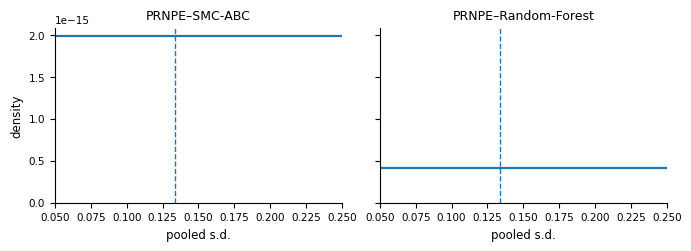

In [21]:
# %%
from __future__ import annotations
from pathlib import Path
from functools import partial
import re, numpy as np, matplotlib.pyplot as plt
import jax, jax.numpy as jnp
from precond_npe_misspec.examples.svar import simulate, summaries, default_pairs

# --- config ---
RESULTS_ROOT = Path("../results/hpc/svar")
GROUP = "th_p10.579_p2-0.143_p30.836_p40.745_p5-0.660_p6-0.254_p70.1-K_6-T_1000-obs_true-n_sims_20000-q_0.2"
SEED = 0
K, T = 6, 1000
N_PPC, BATCH = 2000, 200
XLIM = (0.05, 0.25)
LABELS = {"prnpe": "PRNPE–SMC‑ABC", "rf_abc_rnpe": "PRNPE–Random‑Forest"}
SAVE_DIR = Path("figures")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# --- journal style ---
plt.rcParams.update(
    {
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "font.size": 8.5,
        "axes.labelsize": 8.5,
        "axes.titlesize": 9,
        "xtick.labelsize": 7.5,
        "ytick.labelsize": 7.5,
        "legend.fontsize": 7.5,
    }
)


# --- helpers ---
def _latest_run(p: Path) -> Path | None:
    cand = [
        d for d in p.iterdir() if d.is_dir() and re.fullmatch(r"\d{8}-\d{6}", d.name)
    ]
    return max(cand, key=lambda d: d.stat().st_mtime) if cand else None


def _load_theta(npz_path: Path) -> np.ndarray:
    with np.load(npz_path, allow_pickle=True) as data:
        for k in ("samples", "posterior_samples", "theta", "thetas", "params"):
            if k in data:
                arr = np.asarray(data[k])
                break
        else:
            arr = np.asarray(next(iter(data.values())))
    return (arr.reshape(-1, arr.shape[-1]) if arr.ndim > 1 else arr[:, None]).astype(
        float
    )


def _clean(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, float)
    m = np.isfinite(x) & (x >= 0.0)
    if m.sum() < x.size:
        print(f"[warn] dropped {x.size - m.sum()} / {x.size} non-finite PPC draws")
    return x[m]


def _kde1d(samples: np.ndarray, grid: np.ndarray) -> np.ndarray:
    s = np.asarray(samples, float)
    s = s[np.isfinite(s)]
    if s.size == 0:
        return np.zeros_like(grid)
    sd = np.std(s, ddof=1) if s.size > 1 else 1.0
    bw = max(1e-4, 1.06 * sd * s.size ** (-1 / 5))
    z = (grid[None, :] - s[:, None]) / bw
    return np.exp(-0.5 * z * z).sum(0) / (s.size * bw * np.sqrt(2 * np.pi))


# pairs and pooled-s.d. index
PAIRS = default_pairs(K)
M = int(PAIRS.shape[0])


@partial(jax.jit, static_argnums=(2, 3))
def _pooled_sd_batch(keys: jax.Array, thetas: jax.Array, k: int, T: int) -> jax.Array:
    pairs = PAIRS

    def one(key, th):
        Y = simulate(key, th, k=k, T=T, obs_model="assumed")
        s = summaries(Y, pairs=pairs)
        return s[2 * M]  # pooled s.d.

    return jax.vmap(one)(keys, thetas)


def _ppc_pooled_sd(thetas: np.ndarray, seed: int, n_ppc: int, batch: int) -> np.ndarray:
    rng = np.random.default_rng(seed)
    idx = rng.integers(0, len(thetas), size=n_ppc)
    th = jnp.asarray(thetas[idx])
    out = []
    base = jax.random.PRNGKey(20250916)
    for b0 in range(0, n_ppc, batch):
        th_b = th[b0 : b0 + batch]
        keys_b = jax.random.split(jax.random.fold_in(base, b0), th_b.shape[0])
        out.append(np.asarray(_pooled_sd_batch(keys_b, th_b, K, T)))
    return np.concatenate(out)


# --- load, simulate PPC, observed summary ---
ppc, s_obs_val = {}, None
for mdir in ("prnpe", "rf_abc_rnpe"):
    base = RESULTS_ROOT / mdir / GROUP / f"seed-{SEED}"
    run = _latest_run(base)
    if run is None:
        raise FileNotFoundError(f"No run dir for {mdir}")
    f = run / "posterior_samples.npz"
    if not f.exists():
        f = run / "posterior_samples_robust.npz"
    th = _load_theta(f)
    ppc[mdir] = _clean(_ppc_pooled_sd(th, seed=SEED + 7, n_ppc=N_PPC, batch=BATCH))
    if s_obs_val is None:
        s_obs = np.load(run / "s_obs.npy")
        s_obs_val = float(s_obs[2 * M])

# --- density over fixed range [0.05, 0.25] ---
grid = np.linspace(*XLIM, 700)
dens = {k: _kde1d(v, grid) for k, v in ppc.items()}
ymax = max(d.max() for d in dens.values()) if dens else 1.0

fig, axes = plt.subplots(
    1, 2, figsize=(6.8, 2.4), constrained_layout=True, sharex=True, sharey=True
)
for ax, key in zip(axes, ("prnpe", "rf_abc_rnpe")):
    ax.plot(grid, dens[key], linewidth=1.6)
    if np.isfinite(s_obs_val) and (XLIM[0] <= s_obs_val <= XLIM[1]):
        ax.axvline(s_obs_val, linestyle="--", linewidth=1.0)
    ax.set_xlim(*XLIM)
    ax.set_ylim(0, 1.05 * ymax)
    ax.set_xlabel("pooled s.d.")
    if ax is axes[0]:
        ax.set_ylabel("density")
    ax.set_title(LABELS[key])
    for side in ("top", "right"):
        ax.spines[side].set_visible(False)

fig.savefig(SAVE_DIR / "svar_ppc_pooled_sd_density.pdf", bbox_inches="tight")
fig.savefig(SAVE_DIR / "svar_ppc_pooled_sd_density.png", dpi=300, bbox_inches="tight")
plt.show()

/var/folders/_z/ms2f3nmn0bb7wk4py9_pz7900000gp/T/ipykernel_33696/1717265931.py:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


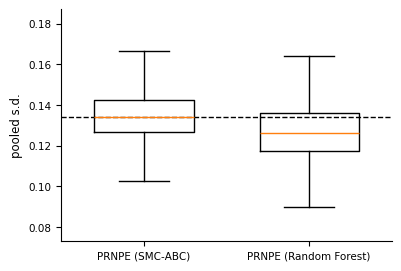

In [35]:
# %%
from __future__ import annotations
import numpy as np, matplotlib.pyplot as plt
from pathlib import Path

# require prior PPC cell
assert "ppc" in globals() and "s_obs_val" in globals(), "Run the PPC cell first."

LABELS = {"prnpe": "PRNPE (SMC‑ABC)", "rf_abc_rnpe": "PRNPE (Random Forest)"}
SAVE_DIR = Path("figures")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

plt.rcParams.update(
    {
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "font.size": 8.5,
        "axes.labelsize": 8.5,
        "axes.titlesize": 9,
        "xtick.labelsize": 7.5,
        "ytick.labelsize": 7.5,
        "legend.fontsize": 7.5,
    }
)


def _clean(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, float)
    m = np.isfinite(x) & (x >= 0.0)
    if m.sum() < x.size:
        print(f"[warn] dropped {x.size - m.sum()} / {x.size} non-finite PPC draws")
    return x[m]


data = [_clean(ppc["prnpe"]), _clean(ppc["rf_abc_rnpe"])]
labels = [LABELS["prnpe"], LABELS["rf_abc_rnpe"]]

# y-limits with padding and ensure obs line visible
# ymin = min(min(d) for d in data if len(d)) if any(len(d) for d in data) else 0.0
# ymax = max(max(d) for d in data if len(d)) if any(len(d) for d in data) else 1.0
# if np.isfinite(s_obs_val):
#     ymin = min(ymin, s_obs_val)
#     ymax = max(ymax, s_obs_val)
ymin = 0.08
ymax = 0.18
pad = 0.07 * (ymax - ymin if ymax > ymin else 1.0)
ylim = (max(0.0, ymin - pad), ymax + pad)

fig, ax = plt.subplots(1, 1, figsize=(3.9, 2.6), constrained_layout=True)
bp = ax.boxplot(
    data,
    vert=True,
    labels=labels,
    showfliers=False,
    widths=0.6,
    patch_artist=False,
    whis=1.5,
)
if np.isfinite(s_obs_val):
    ax.axhline(s_obs_val, linestyle="--", linewidth=1.0, color="black")

ax.set_ylim(*ylim)
ax.set_ylabel("pooled s.d.")
ax.tick_params(axis="x", rotation=0)
for side in ("top", "right"):
    ax.spines[side].set_visible(False)

fig.savefig(SAVE_DIR / "svar_ppc_pooled_sd_boxplot.pdf", bbox_inches="tight")
fig.savefig(SAVE_DIR / "svar_ppc_pooled_sd_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()

[array([0.14280248, 0.11972502, 0.14041476, ..., 0.13938899, 0.12424733,
        0.10843271], shape=(1998,)),
 array([0.11966196, 0.11097986, 0.16689532, ..., 0.11841638, 0.103532  ,
        0.13717414], shape=(1991,))]

In [18]:
np.quantile(ppc["rf_abc_rnpe"], 0.98)

np.float64(0.2162075132131578)